<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based method with linear drift (Ornstein–Uhlenbeck process). Check for the 2th order solver.
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver1
from solver_tmp import SolverTmp as Solver2

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

In [2]:
A = 1.
s = 1.
dc = 0.5

def func_f0(x, t):
    m = 0.
    return A * (m - x)

def func_f1(x, t):
    return -A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    m = 0.
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_init = func_r0(X.reshape(1, -1))
    r_real = func_rt(X.reshape(1, -1), t_max)
    r_stat = func_rs(X.reshape(1, -1))
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    plt.plot(
        X.reshape(-1), r_init, '--', label='Initial',
        linewidth=3, color='tab:blue'
    )
    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.plot(
        X.reshape(-1), r_stat, '--', label='Stationary',
        linewidth=2, color='magenta'
    )
    
    plt.title('Solution at final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)

In [13]:
t_poi = 100
t_min = 0.
t_max = 0.5

x_poi = 100
x_min = -5.
x_max = +5.

m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

print('Time-space factor (h/l^2) : %-8.5f'%(h/l/l))

Time-space factor (h/l^2) : 0.50505 


In [14]:
SL1 = Solver1(d=1, with_tt=False)
SL1.set_grid_t(t_poi, t_min, t_max, t_poi_hst=3)
SL1.set_grid_x(x_poi, x_min, x_max)
SL1.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL1.set_coefs(dc)
SL1.prep()
SL1.calc()
SL1.plot_x()
SL1.info()

Solve: 100%|█| 99/99 [00:00<00:00, 180.81step/s, | At T = 5.00e-01 : error=1.81e-03]


In [15]:
SL2 = Solver2(d=1, with_tt=False)
SL2.set_grid_t(t_poi, t_min, t_max, t_poi_hst=3)
SL2.set_grid_x(x_poi, x_min, x_max)
SL2.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL2.set_coefs(dc)
SL2.prep()
SL2.calc()
SL2.plot_x()
SL2.info()

Solve: 100%|█| 99/99 [00:15<00:00,  8.67step/s, | At T = 5.00e-01 : error=1.02e-03]


In [22]:
n = 100
M = [10, 100, 1000, 5000] #, 10000]
Times1 = []
Errors1 = []
Times2 = []
Errors2 = []

def calc(SL, Times, Errors, m):
    SL.set_grid_t(m, t_min, t_max, t_poi_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(dc)
    SL.prep()
    SL.calc()
    u_calc = SL.R_hst[-1]
    u_real = func_rt(SL.X_hst.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)
    
for m in M:
    calc(Solver1(d=1, ord=1), Times1, Errors1, m)
    calc(Solver2(d=1, ord=1), Times2, Errors2, m)

Solve: 100%|█| 4999/4999 [14:47<00:00,  5.86step/s, | At T = 5.00e-01 : error=2.01e-05]


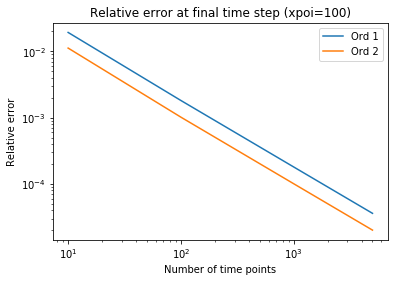

In [23]:
plt.plot(M, Errors1, label='Ord 1')
plt.plot(M, Errors2, label='Ord 2')
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Relative error')
plt.legend(loc='best')
plt.show()

plt.plot(M, [t[1] for t in Times1], label='Ord 1')
plt.plot(M, [t[1] for t in Times2], label='Ord 2')
plt.semilogx()
plt.semilogy()
plt.title('Calculation time (sec.; xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Time, sec')
plt.legend(loc='best')
plt.show()

<div class="end"></div>